In [5]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from pre_processing import load_and_clean_data

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
df = load_and_clean_data(
    "../diabetes_prediction_dataset.csv", split=False, standardize=False)


In [20]:
X = df.drop(columns="diabetes")

In [21]:
y = df["diabetes"]

In [22]:
def rule_based_classifier(X):
    bmi_threshold = 30
    age_threshold = 50
    
    # Check if the smoking history columns exist
    risk_smoking_cols = []
    if 'smoking_history_former' in X.columns:
        risk_smoking_cols.append('smoking_history_former')
    if 'smoking_history_other' in X.columns:
        risk_smoking_cols.append('smoking_history_other')

    # Combine smoking history risk conditions
    if risk_smoking_cols:
        smoking_risk = X[risk_smoking_cols].sum(axis=1) > 0
    else:
        smoking_risk = pd.Series([False] * len(X), index=X.index)

    # Final rule-based prediction
    predictions = (
        (X["bmi"] > bmi_threshold) |
        (X["age"] > age_threshold) |
        smoking_risk
    ).astype(int)

    return predictions


In [26]:
y_pred_rules = rule_based_classifier(X)

In [27]:
# Evaluation
print("Rule-Based Classifier Report:")
print(classification_report(y, y_pred_rules, digits=4))

Rule-Based Classifier Report:
              precision    recall  f1-score   support

           0     0.9826    0.5058    0.6678     87664
           1     0.1508    0.9073    0.2587      8482

    accuracy                         0.5412     96146
   macro avg     0.5667    0.7066    0.4632     96146
weighted avg     0.9092    0.5412    0.6317     96146



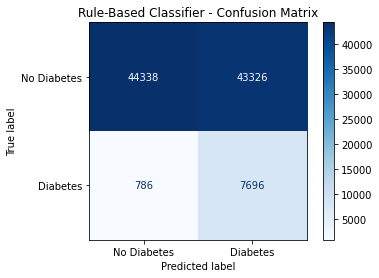

In [28]:
# Evaluation: confusion matrix
cm = confusion_matrix(y, y_pred_rules)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Rule-Based Classifier - Confusion Matrix")
plt.show()

In [29]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [45]:
# Load and preprocess dataset
df = load_and_clean_data("../diabetes_prediction_dataset.csv", split=False, standardize=False)
X = df.drop(columns="diabetes")
y = df["diabetes"]

In [46]:
# Feature names needed for rule logic
feature_names = X.columns

In [47]:
# Rule-based classifier wrapped in scikit-learn estimator
class RuleBasedClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, bmi_threshold=30, age_threshold=50):
        self.bmi_threshold = bmi_threshold
        self.age_threshold = age_threshold

    def fit(self, X, y=None):
        return self  # No fitting needed

    def predict(self, X):
        # Ensure X is a DataFrame with correct columns
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=feature_names)

        smoking_risk = pd.Series([False] * len(X), index=X.index)
        if 'smoking_history_former' in X.columns or 'smoking_history_other' in X.columns:
            smoking_risk = (
                X.get('smoking_history_former', 0) + X.get('smoking_history_other', 0)
            ) > 0

        preds = (
            (X["bmi"] > self.bmi_threshold) |
            (X["age"] > self.age_threshold) |
            smoking_risk
        ).astype(int)

        return preds

In [48]:
# Create rule-based classifier instance
rule_clf = RuleBasedClassifier()

In [49]:
# Custom F1 scorer for the minority class (positive class = 1)
f1_minority = make_scorer(f1_score, pos_label=1, zero_division=0)

In [50]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [51]:
# Compute cross-validated F1 scores
cv_scores = cross_val_score(rule_clf, X, y, scoring=f1_minority, cv=cv)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/_response.py", line 182, in _get_response_values
    classes = estimator.classes_
AttributeErro

In [52]:
# Output results
print("Cross-validated F1 scores:", cv_scores)
print("Mean CV F1 score:", np.mean(cv_scores))

Cross-validated F1 scores: [nan nan nan nan nan nan nan nan nan nan]
Mean CV F1 score: nan


In [39]:
# Optional: full evaluation on entire dataset
y_pred = rule_clf.predict(X)
print("\nRule-Based Classifier Report:")
print(classification_report(y, y_pred, digits=4))


Rule-Based Classifier Report:
              precision    recall  f1-score   support

           0     0.9826    0.5058    0.6678     87664
           1     0.1508    0.9073    0.2587      8482

    accuracy                         0.5412     96146
   macro avg     0.5667    0.7066    0.4632     96146
weighted avg     0.9092    0.5412    0.6317     96146

